In [1]:
# import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# read csv data
data = pd.read_csv("time_series_covid19_confirmed_global.csv", index_col=0)

# get the countries' name
countries = data["Country/Region"]

# extract the starting date up to the last date
x = list(data.columns)
x = x[3:]

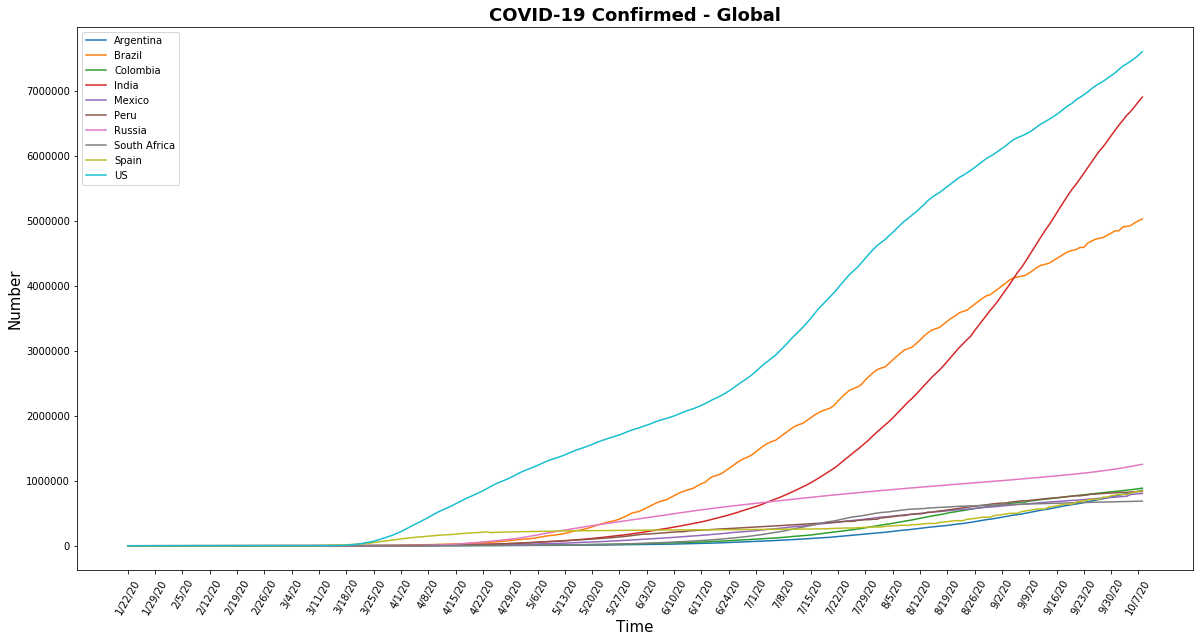

In [2]:
## last-date confirmed cases analysis ##
# get the rank of each country based on the number of last date confirmed cases,
# save it in a new data column 'Rank_Global'
# select top ten rank and save it under new data column 'Selected_Global'
data["Rank_Global"] = data[x[-1]].rank(ascending=False)
data["Selected_Global"] = data["Rank_Global"] <= 10

# plot top ten countries based on the number of last date confirmed cases
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111)
for i in range(len(countries)):
    if data["Selected_Global"][i]:
        y = data.iloc[i,3:-2]
        if np.isnan(data.index[i]):
            lbl = str(data.iloc[i,0])
        else:
            lbl = str(data.iloc[i,0]) + " - " + str(data.index[i])
        ax.plot(x, y, label=lbl)

ind = [i for i in range(0, len(x), 7)]
date = [x[i] for i in ind]
plt.xticks(ind, date, rotation=60)

# title, label, and legend
ax.set_title("COVID-19 Confirmed - Global", fontsize=18, fontweight='bold')
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Number', fontsize=15)
ax.legend()

fig.savefig('Top Ten Countries.jpg', bbox_inches = 'tight')

In [3]:
# Simple Moving Average
def SMA(src, period):
    sma = [None] * len(src)
    for i in range(len(src)-period+1):
        sma[i+period-1] = np.average(src[i:(i+period)])
    return sma

In [4]:
# Weighted Moving Average
def WMA(src, period):
    wma = [None] * len(src)
    wts = np.array([i+1 for i in reversed(range(period))])
    for i in range(len(src)-period+1):
        wma[i+period-1] = np.average(list(reversed(src[i:(i+period)])), weights = wts)
    return wma

In [5]:
# Exponential Moving Average
def EMA(src, alpha):
    ema = []
    for i in range(len(src)):
        if i == 0:
            ema.append(src[i])
        else:
            ema.append((alpha * src[i]) + ((1 - alpha) * ema[i-1]))
    return ema

In [6]:
# Hull Moving Average
def HMA(src, period):
    hma = [None] * len(src)
    inp = [None] * len(src)
    wmaHalf = WMA(src, math.floor(period/2))
    wmaFull = WMA(src, period)
    inp[period-2] = src[period-2]   
    for i in range(len(src)-period+1):
        inp[i+period-1] = (2 * wmaHalf[i+period-1]) - wmaFull[i+period-1]
        hma[i+period-1] = ((2 * inp[i+period-1]) + inp[i+period-2]) / ( 2 + 1)
    return hma

In [7]:
# Weighted Exponential Moving Average
def WEMA(src, period, alpha):   
    wema = [None] * len(src)
    wmaFull = WMA(src, period)
    wema[period-2] = src[period-2]   
    for i in range(len(src)-period+1):
        wema[i+period-1] = ((alpha * wmaFull[i+period-1]) + ((1 - alpha) * wema[i+period-2]))
    return wema

In [8]:
# Hull Weighted Exponential Moving Average
def HullWEMA(src, period, alpha):   
    hullWema = [None] * len(src)
    hma = HMA(src, period)
    hullWema[period-2] = src[period-2]   
    for i in range(len(src)-period+1):
        hullWema[i+period-1] = ((alpha * hma[i+period-1]) + ((1 - alpha) * hullWema[i+period-2]))
    return hullWema

In [9]:
# Forecast Error Criteria
def errCalc(src, pred, startInd):
    # Mean Square Error (MSE) & Root Mean Square Error (RMSE)
    diff2 = [(src[i] - pred[i])**2 for i in range(startInd, len(src))]
    sumDiff2 = sum(diff2)
    mse = sumDiff2 / len(diff2)
    rmse = math.sqrt(mse)
    # Mean Absolute Error (MAE)
    diffAbs = [abs(src[i] - pred[i]) for i in range(startInd, len(src))]
    sumDiffAbs = sum(diffAbs)
    mae = sumDiffAbs / len(diffAbs)
    # Mean Absolute Percentage Error (MAPE)
    diffMape = [abs((src[i] - pred[i]) / src[i]) for i in range(startInd, len(src))]
    sumDiffMape = sum(diffMape)
    mape = (sumDiffMape / len(diffMape)) * 100
    # Mean Absolute Scale Error (MASE)
    diffAct = [abs(src[i] - src[i-1]) for i in range(startInd, len(src))]
    sumDiffAct = sum(diffAct)
    diffQt = [abs((src[i] - pred[i]) / ((1 / (len(diffAct) - 1)) * sumDiffAct)) for i in range(startInd, len(src))]
    sumDiffQt = sum(diffQt)
    mase = sumDiffQt / len(diffQt)
    return mse, rmse, mae, mape, mase

In [39]:
# Train-Test Phase
# <<INPUT>> - read the 'considered' country data
country = 'US'
data = pd.read_csv(country + "_all.csv", index_col=0)

# extract the starting date up to the last date
x = list(data.columns)
x = x[3:]

procData = data.iloc[0,3:]

# <<INPUT>> - train test split ratio
split = 0.8

trainData = procData[0:int(split * len(procData))]
testData = procData[int(split * len(procData)):]
print("Country: " + country)
print("Train: {}, Test: {}, Total: {}".format(len(trainData), len(testData), len(procData)))

# <<INPUT>> - period and iteration number
period = 7
iter = 100

# HMA Prediction
finPredHMA = HMA(procData, period)
finMse, finRmse, finMae, finMape, finMase = errCalc(procData, finPredHMA, period-1)
print()
print("-----------HMA----------")
print('MSE: {}, RMSE: {}, MAE: {}, MAPE: {}, MASE: {}, Prediction: {}'.format(finMse, finRmse, finMae, finMape, finMase, finPredHMA))

# WEMA iteration - Train Phase
initMape = 100
finPredWEMA = []
alpha = 0
for i in range(iter):
    wema = WEMA(trainData, period, i/iter)
    mse, rmse, mae, mape, mase = errCalc(trainData, wema, period-1)
    if mape < initMape:
        initMape = mape
        finPredWEMA = wema
        alpha = i/iter
        finMse, finRmse, finMae, finMape, finMase = errCalc(trainData, finPredWEMA, period-1)
print()
print("-----------WEMA - Train----------")
print('alpha: {}, MSE: {}, RMSE: {}, MAE: {}, MAPE: {}, MASE: {}, Prediction: {}'.format(alpha, finMse, finRmse, finMae, finMape, finMase, finPredWEMA))

# Hull-WEMA iteration - Train Phase
initMape = 100
finPredHullWEMA = []
alpha = 0
for i in range(iter):
    hullWema = HullWEMA(trainData, period, i/iter)
    mse, rmse, mae, mape, mase = errCalc(trainData, hullWema, period-1)
    if mape < initMape:
        initMape = mape
        finPredHullWEMA = hullWema
        alpha = i/iter
        finMse, finRmse, finMae, finMape, finMase = errCalc(trainData, finPredHullWEMA, period-1)
print()
print("-----------Hull-WEMA - Train----------")
print('alpha: {}, MSE: {}, RMSE: {}, MAE: {}, MAPE: {}, MASE: {}, Prediction: {}'.format(alpha, finMse, finRmse, finMae, finMape, finMase, finPredHullWEMA))

Country: US
Train: 208, Test: 53, Total: 261

-----------HMA----------
MSE: 149857780.338521, RMSE: 12241.641243661776, MAE: 9529.707298474932, MAPE: 1.5618183888865589, MASE: 0.31824712890266194, Prediction: [None, None, None, None, None, None, 5.785714285714286, 6.345238095238095, 6.492063492063491, 7.484126984126984, 8.400793650793652, 8.753968253968255, 10.083333333333334, 11.45238095238095, 12.035714285714285, 12.30952380952381, 12.48015873015873, 12.484126984126982, 12.297619047619046, 12.142857142857144, 12.55952380952381, 13.063492063492065, 13.805555555555557, 14.313492063492063, 14.448412698412698, 14.321428571428571, 14.154761904761905, 14.05952380952381, 14.011904761904761, 14.0, 15.0, 16.103174603174605, 16.61111111111111, 16.523809523809526, 16.28571428571429, 16.119047619047617, 16.523809523809522, 17.0515873015873, 21.305555555555554, 29.174603174603178, 46.4484126984127, 69.98015873015872, 101.49603174603173, 160.5079365079365, 233.3293650793651, 359.0714285714286, 512


-----------Hull-WEMA - Train----------
alpha: 0.99, MSE: 123772218.66703366, RMSE: 11125.296340638915, MAE: 8122.533494831715, MAPE: 1.9171756411207517, MASE: 0.3023528565520418, Prediction: [None, None, None, None, None, 5, 5.777857142857142, 6.339564285714286, 6.490538499999999, 7.474191099285715, 8.391527625278574, 8.750343847681357, 10.070003438476814, 11.43855717724191, 12.029742714629561, 12.306725998574867, 12.478424402842892, 12.484069958314143, 12.299483556725997, 12.144423406995832, 12.55537280549853, 13.05841087091213, 13.798084108709123, 14.308337983944234, 14.447011951268014, 14.322684405226966, 14.156441129766556, 14.060492982726236, 14.012390644112974, 14.000123906441129, 14.99000123906441, 16.092042869533504, 16.605920428695335, 16.524630632858383, 16.28810344918573, 16.120738177348997, 16.519778810344917, 17.046269216674876, 21.262962692166745, 29.095486769778812, 46.27488343912636, 69.74310597724839, 101.1785024883439, 159.91464216774057, 232.59521785024884, 357.8066

In [40]:
# WEMA - Test Phase
# <<INPUT>> - best alpha from Train Phase
alpha = 0.99

wemaTest = WEMA(testData, period, alpha)
finMse, finRmse, finMae, finMape, finMase = errCalc(testData, wemaTest, period-1)
print("-----------WEMA - Test----------")
print('alpha: {}, MSE: {}, RMSE: {}, MAE: {}, MAPE: {}, MASE: {}, Prediction: {}'.format(alpha, finMse, finRmse, finMae, finMape, finMase, wemaTest))

# Hull-WEMA - Test Phase
# <<INPUT>> - best alpha from Train Phase
alpha = 0.99

hullWemaTest = HullWEMA(testData, period, alpha)
finMse, finRmse, finMae, finMape, finMase = errCalc(testData, hullWemaTest, period-1)
print()
print("-----------Hull-WEMA - Test----------")
print('alpha: {}, MSE: {}, RMSE: {}, MAE: {}, MAPE: {}, MASE: {}, Prediction: {}'.format(alpha, finMse, finRmse, finMae, finMape, finMase, hullWemaTest))

-----------WEMA - Test----------
alpha: 0.99, MSE: 6901980273.518404, RMSE: 83078.15761990876, MAE: 82684.40094634166, MAPE: 1.2527134520589556, MASE: 1.9597629433480936, Prediction: [None, None, None, None, None, 5665086, 5617029.738214286, 5657518.734525001, 5697688.424130964, 5738600.426027024, 5780537.571045984, 5823519.835710459, 5867575.387285676, 5910007.747444285, 5950548.851045872, 5991298.388510459, 6031648.636027962, 6072572.661717422, 6115681.026260031, 6159352.693476886, 6200443.3712204825, 6237319.867283634, 6270998.844029979, 6303735.823440299, 6336497.643948689, 6372323.798225201, 6409752.326910823, 6447263.6336262515, 6484551.214907691, 6522560.461077648, 6560702.052825063, 6600322.649099679, 6642126.312205283, 6684923.031336339, 6726658.006027649, 6771276.3454174185, 6814821.754525604, 6857130.991116685, 6899617.097411167, 6943912.464902683, 6988553.367506169, 7031404.729389347, 7071668.120508179, 7112187.746562224, 7152709.192465622, 7193952.472638942, 7238317.829369

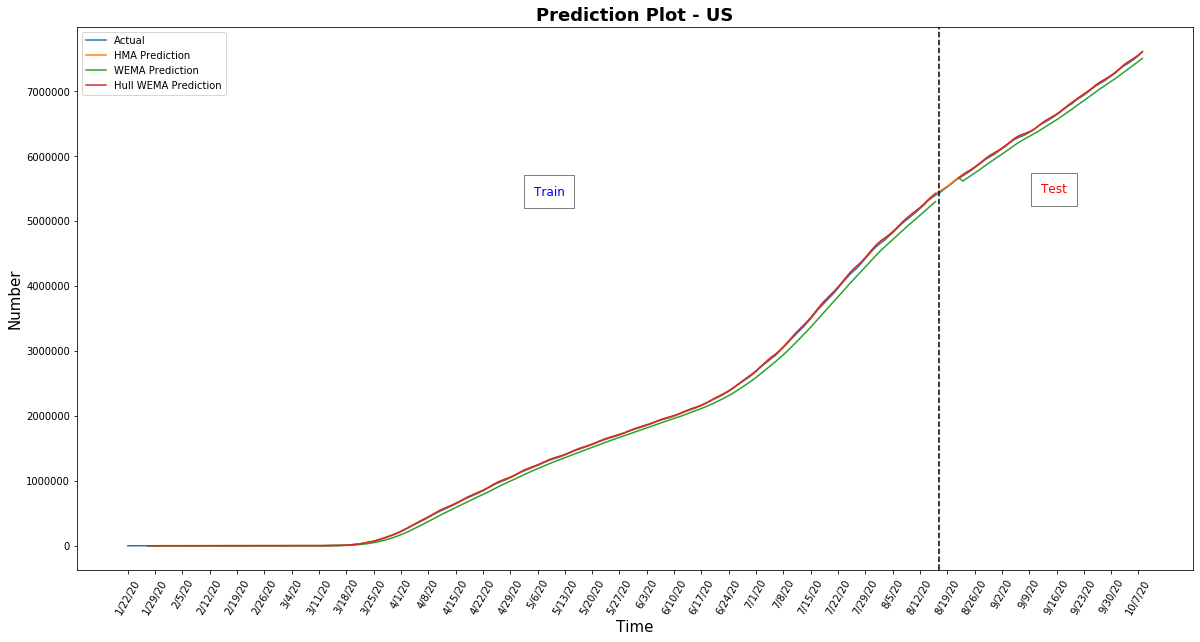

In [41]:
# combine the Train-Test results for WEMA and Hull-WEMA
allWEMA = finPredWEMA + wemaTest
allHullWEMA = finPredHullWEMA + hullWemaTest

# plot the actual and prediction results
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111)
ax.plot(x, procData, label="Actual")
ax.plot(x, finPredHMA, label="HMA Prediction")
ax.plot(x, allWEMA, label="WEMA Prediction")
ax.plot(x, allHullWEMA, label="Hull WEMA Prediction")

ind = [i for i in range(0, len(x), 7)]
date = [x[i] for i in ind]
plt.xticks(ind, date, rotation=60)
plt.legend()

# title
ax.set_title("Prediction Plot - " + country, fontsize=18, fontweight='bold')

# axis title
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Number', fontsize=15)

# text
xTrain = int(len(trainData)/2)
yTrain = int(max(trainData))
xTest = len(trainData) + int(len(testData)/2)
yTest = int(min(testData))
ax.text(xTrain, yTrain, 'Train', fontsize=12, color='blue', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
ax.text(xTest, yTest, 'Test', fontsize=12, color='red', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
plt.axvline(x=len(trainData), color='k', linestyle='--')